# Tutorial of implementing Drop out
mnist image를 분류하는 Convolution Neural Network에 Drop out을 적용하는 간단한 example

Drop out paper : http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

### Setup

In [1]:
import os, sys
import shutil 
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data # load mnist dataset
mnist = input_data.read_data_sets(train_dir = './MNIST_data', one_hot = True, reshape = True, seed = 777)

Extracting ./MNIST_data\train-images-idx3-ubyte.gz
Extracting ./MNIST_data\train-labels-idx1-ubyte.gz
Extracting ./MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data\t10k-labels-idx1-ubyte.gz


### Define MnistCNN class
conv-conv-max pool-conv-conv-max pool-fc-fc

In [2]:
'''
Drop out의 구현을 위해서는 tf.nn module에 있는 tf.nn.dropout을 활용한다. tf.nn.dropout의 wrapper로 
tf.layers.dropout이 있지만 해당 api는 default rate가 정해져있고, dropout을 걸지 안 걸지를 결정하기위해서
training argument가 존재하는데, 두 가지를 다 조절하려면 두 개의 tf.placeholder가 필요하기 때문에 개인 선호에 의해서
tf.nn.dropout을 활용한다.(tf.nn.dropout은 keep_prob argument 하나만 존재)
일반적인 Convolution Neural Network에 적용할 때는, 마지막 output layer (label의 개수와 같은 fc layer) 전의 fc layer에
Drop out을 적용한다.
(Convolution Neural Network의 Filter에 적용하는 논문도 있다. 이는 drop connect 논문과 비슷한 발상에서 나온 것 같다)
'''
class MnistCNN:
    def __init__(self, activation_fn = tf.nn.relu, initializer = tf.contrib.layers.variance_scaling_initializer(),
                 l2_scale = .5):
        
        with tf.variable_scope('input_layer'):
            self._x = tf.placeholder(dtype = tf.float32, shape = [None,784])
            self._ximg = tf.reshape(tensor = self._x, shape = [-1,28,28,1])
            self._y = tf.placeholder(dtype = tf.float32, shape = [None,10])
            self._keep_prob = tf.placeholder(dtype = tf.float32)
            
        with tf.variable_scope('conv_layer1'):
            _conv_pre = tf.layers.conv2d(inputs = self._ximg, filters = 64, kernel_size = [3,3],
                                        kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale),
                                        padding = 'same')
            _conv_relu = activation_fn(_conv_pre)
            
        with tf.variable_scope('conv_layer2'):
            _conv_pre = tf.layers.conv2d(inputs = _conv_relu, filters = 64, kernel_size = [3,3],
                                        kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale),
                                        padding = 'same')
            _conv_relu = activation_fn(_conv_pre)
            
        with tf.variable_scope('max_pool1'):
            _pooled = tf.layers.max_pooling2d(inputs = _conv_relu, pool_size = [2,2], strides = 2)
            
        with tf.variable_scope('conv_layer3'):
            _conv_pre = tf.layers.conv2d(inputs = _pooled, filters = 128, kernel_size = [3,3],
                                        kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale),
                                        padding = 'same')
            _conv_relu = activation_fn(_conv_pre)
            
        with tf.variable_scope('conv_layer4'):
            _conv_pre = tf.layers.conv2d(inputs = _conv_relu, filters = 128, kernel_size = [3,3],
                                        kernel_initializer = initializer,
                                        kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale),
                                        padding = 'same')
            _conv_relu = activation_fn(_conv_pre)
            
        with tf.variable_scope('max_pool2'):
            _pooled = tf.layers.max_pooling2d(inputs = _conv_relu, pool_size = [2,2], strides = 2)
        
        with tf.variable_scope('dense_layer1'):
            _pooled_vector = tf.reshape(tensor = _pooled, shape = [-1,np.cumprod(_pooled.get_shape().as_list()[-3:])[-1]])
            _fc_pre = tf.layers.dense(inputs = _pooled_vector, units = 1024, kernel_initializer = initializer,
                                  kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
            _fc_relu = activation_fn(_fc_pre)
            _fc_relu = tf.nn.dropout(x = _fc_relu, keep_prob = self._keep_prob)
            
        with tf.variable_scope('output_layer'):
            self._score = tf.layers.dense(inputs = _fc_relu, units = 10, kernel_initializer = initializer,
                                          kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
            
        with tf.variable_scope('loss'):
            self._ce_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self._score, labels = self._y))
        ''' 
           각각 mini_batch 마다의 mean과 variance를 계산하고, 이를 Exponential Moving Average로 저장하는 과정이 필요한 데,
           이를 수행하기위해 tf.get_collection(tf.GraphKeys.UPDATE_OPS)에서 뽑히는 ops를 저장해둔다. 이 op들은 후에
           tf.control_dependencies의 control_inputs argument에 전달된다.
           
           Note: when training, the moving_mean and moving_variance need to be updated.
           By default the update ops are placed in `tf.GraphKeys.UPDATE_OPS`, so they
           need to be added as a dependency to the `train_op`. For example:

                
               update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS) <-- 본 example에서는 model 생성 class 코드에 들어가고,
                                                                           객체변수로 저장한다.
               
               with tf.control_dependencies(update_ops): <-- Solver class는 코드에 들어간다. Solver class는 model class
                   train_op = optimizer.minimize(loss)      생성된 instance를 input으로 받으므로, 거기에서 객체변수로 
                                                             저장된 update_ops를 tf.control_dependencies의 argument에 전달한다.
        '''
        # 객체변수에 model class 코드로 생성되는 graph의 UPDATE_OPS를 저장
                
        with tf.variable_scope('predict'):
            self._prediction = tf.argmax(input = self._score, axis = 1)
    
    def predict(self, sess, x_data, keep_prob = 1.):
        feed_predict = {self._x : x_data, self._keep_prob : keep_prob}
        return sess.run(fetches = self._prediction, feed_dict = feed_predict)

### Define Solver class

In [3]:
class Solver:
    def __init__(self, model, optimizer = tf.train.AdamOptimizer, var_list = None):
        self._model = model
        self._lr = tf.placeholder(dtype = tf.float32)
        self._optimizer = optimizer(learning_rate = self._lr)
        self._training_op = self._optimizer.minimize(loss = self._model._ce_loss, var_list = var_list)
    
    def train(self, sess, x_data, y_data, lr, keep_prob = .5):
        feed_train = {self._model._x : x_data, self._model._y : y_data, self._lr : lr,
                      self._model._keep_prob : keep_prob}
        return sess.run(fetches = [self._training_op, self._model._ce_loss], feed_dict = feed_train)
            
    def evaluate(self, sess, x_data, y_data, keep_prob = 1.):
        feed_loss = {self._model._x : x_data, self._model._y : y_data, self._model._keep_prob : keep_prob}
        return sess.run(fetches = self._model._ce_loss, feed_dict = feed_loss)

### Generate CNN model and Adam solver### 

In [4]:
sess = tf.Session()
mnist_classifier = MnistCNN()

In [5]:
adam_solver = Solver(model = mnist_classifier)

### Training

In [6]:
# Hypear-parameters
batch_size = 100
n_epochs = 3
best_loss = np.infty
max_checks_without_progress = 15
checks_without_progress = 0
tr_loss_history = []
val_loss_history = []

In [7]:
sess.run(tf.global_variables_initializer())

In [8]:
for epoch in range(n_epochs):
    avg_tr_loss = 0
    avg_val_loss = 0
    total_batch = int(5000 / batch_size)
    
    for step in range(total_batch):
        
        batch_xs, batch_ys = mnist.train.next_batch(batch_size = batch_size)
        val_xs, val_ys = mnist.validation.next_batch(batch_size = batch_size)
        _, tr_loss = adam_solver.train(sess = sess, x_data = batch_xs, y_data = batch_ys, lr = 1e-3, keep_prob = .5)
        val_loss = adam_solver.evaluate(sess = sess, x_data = val_xs, y_data = val_ys, keep_prob = 1)
        
        avg_tr_loss += tr_loss / total_batch
        avg_val_loss += val_loss / total_batch
        if step % 100 == 0:
            print('step : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(step, tr_loss, val_loss))
    
    print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch, avg_tr_loss, avg_val_loss))
    tr_loss_history.append(avg_tr_loss)
    val_loss_history.append(avg_val_loss)
    
     # early stopping
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        checks_without_progress = 0
    else:
        checks_without_progress += 1
        if checks_without_progress > max_checks_without_progress:
            print('Early stopping')
            break

step :   0, tr_loss : 2.683, val_loss : 4.558
epoch :   0, tr_loss : 0.781, val_loss : 0.634
step :   0, tr_loss : 0.105, val_loss : 0.170
epoch :   1, tr_loss : 0.147, val_loss : 0.110
step :   0, tr_loss : 0.032, val_loss : 0.093
epoch :   2, tr_loss : 0.104, val_loss : 0.074


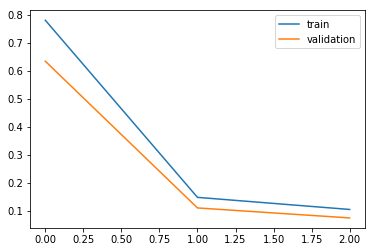

In [9]:
plt.plot(tr_loss_history, label = 'train')
plt.plot(val_loss_history, label = 'validation')
plt.legend()

In [10]:
hat = mnist_classifier.predict(sess=sess, x_data=mnist.test.images, keep_prob=1.)

In [11]:
print('accuracy : {:.2%}'.format(np.mean(np.argmax(mnist.test.labels, axis = 1) == hat)))

accuracy : 97.86%
